TASK 1 - IMPORTING THE MODEL

In [0]:
import tensorflow as tf

In [3]:
# model = tf.keras.models.load_model('/content/model/cats_vs_dogs.h5')
model = tf.keras.models.load_model('/content/model/cats_vs_dogs.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Task 2 - TESTING THE MODEL

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [0]:
classes = ['Cat','Dog']
def display_prediction(image_path): # pre-processing on image 
  plt.imshow(plt.imread(image_path)) # take a look on image 
  x = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128)) # open the image
  x=tf.keras.preprocessing.image.img_to_array(x) # convert x to numpy
  x=tf.keras.applications.mobilenet_v2.preprocess_input(x) # normalizing x
  x=np.expand_dims(x,axis=0) # expanding dimensions

  pred = model.predict(x)[0] # [0] - 1st element of prediction   # jeryyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

  plt.title('Pred: {}'.format(classes[int(pred>0.5)])) # if pred<0 then image is cat else image is dog
  plt.show()
  print(pred)

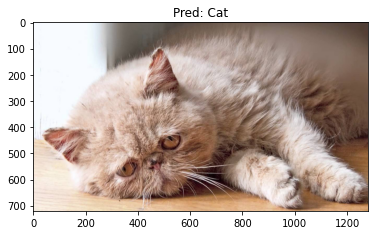

[0.00418769]


In [6]:
images = ['/content/images/cat1.jpg','/content/images/cat2.jpg','/content/images/dog1.jpg','/content/images/dog2.jpg']

display_prediction(images[0])

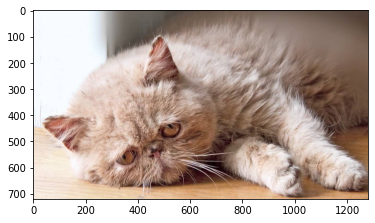

In [7]:
image_path_demo=images[0]
plt.imshow(plt.imread(image_path_demo)) # take a look on image 

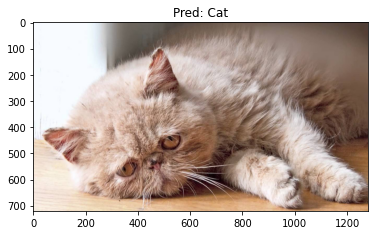

[0.00418769]


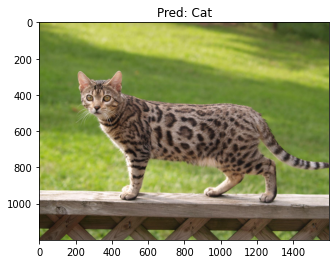

[0.00043299]


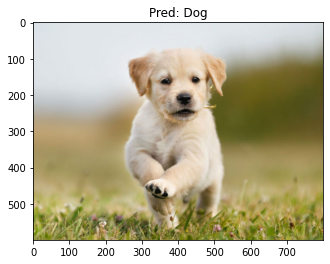

[0.9987244]


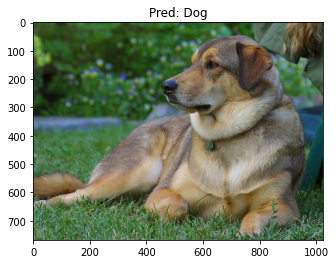

[0.9928952]


In [8]:
for x in images:
  display_prediction(x) 

In [10]:
%%writefile predicton.py

import tensorflow as tf
import numpy as np 
import os 
import base64

MODEL_NAME = 'cats_vs_dogs.h5'
CLASS_NAMES = ['Cat', 'Dog']

class CatsVsDogsPrediction:
  def __init__(self, model):
    self.model=model

  def _preprocess(self, instances, size=128): # _a() - a() is a private function
    num_examples = len(instances)
    x_batch = np.zeros((num_examples, size, size, 3)) # x_batch is a placeholder
    for i in range(num_examples):
      x = np.array(bytearray(base64.b64decode(instances[i]))) # decode data string into byte and then to numpy array
      x = np.reshape(x, (size, size, 3))
      x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # normalizing data 
      x_batch[i] = x
    return x_batch
  
  def _postprocess(self, preds):
    results = []
    for i, pred in enumerate(preds):
      p = np.sqeeze(pred) # np.squeeze is to remove any extra dimensions if there are any
      results.append({
          'index': i,
          'class_name': CLASS_NAMES[int(p>0)], # if p>0 then 1 else 0
          'raw_value' : '{:.4f}'.format(p)
      })
    return results

  def predict(self, instances, **kwargs):
    if 'size' in kwargs:
      size = int(kwargs.get('size'))
    else:
      size = 128
    # Preprocessing 
    x_batch = self._preprocess(instances, size)
    # Predict 
    preds = self._model.predict(x_batch)
    # Post processing 
    results = self._postprocess(preds)
    return results


  @classmethod
  def from_path(cls, model_dir):
    model = tf.keras.models.load_model(os.path.join(model_dir, MODEL_NAME))
    return cls(model) # returning the instance of class cls

Overwriting predicton.py


In [16]:
%%writefile setup.py
from setuptools import setup

setup(
    name='cats_vs_dogs',
    version='0.0.1',
    include_package_data=False,
    scripts=['prediction.py']
)

Overwriting setup.py


In [17]:
# creating our package 
!python3 setup.py sdist --format=gztar

running sdist
running egg_info
creating cats_vs_dogs.egg-info
writing cats_vs_dogs.egg-info/PKG-INFO
writing dependency_links to cats_vs_dogs.egg-info/dependency_links.txt
writing top-level names to cats_vs_dogs.egg-info/top_level.txt
writing manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'
reading manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'
writing manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'

running check


creating cats_vs_dogs-0.0.1
creating cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying files to cats_vs_dogs-0.0.1...
copying setup.py -> cats_vs_dogs-0.0.1
copying cats_vs_dogs.egg-info/PKG-INFO -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/SOURCES.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/dependency_links.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/top_level.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
Writing cats_vs_dogs-0.0.1/setup.cfg
creating dist
Creating tar ar

Now we will upload 'cats_vs_dogs.egg-info' file to google storage.

In [0]:
# copying file to google cloud 
!gsutil cp dist/cats_vs_dogs-0.0.1.tar.gz gs://rhyme-bucket/dist/

# ***To get Output After Deploy-***

In [0]:
from googleapiclient import discovery 
from PIL import Image 
import os 
import base64

In [0]:
service = discovery.build('ml','v1',cache_discovery=False)

In [0]:
def get_pred_from_model(body, project_name, model_name):
  return service.projects().predict(
      name='projects/{}/models/{}'.format(project_name, model_name),
      body=body
  ).execute()

In [0]:
project_name='rhyme-269417' # you will get project_name from google cloud
model_name='cats_vs_dogs'

In [23]:
images

['/content/images/cat1.jpg',
 '/content/images/cat2.jpg',
 '/content/images/dog1.jpg',
 '/content/images/dog2.jpg']

In [0]:
instances=[]
size=128

for image in images:
  img = Image.open(image) # opening image 
  img = img.resize((size, size), Image.ANTIALTAS)

  instances.append(
      base64.b64encode(img.tobytes()).decode()
  )
  img.close()

In [0]:
body = {
    'instances':instances,
    'size':size
}

In [0]:
response = get_pred_from_model(body, project_name, model_name)

In [0]:
response